This is my PyTorch implementation of the Proposed Method in the following paper:
https://www.sciencedirect.com/science/article/pii/S0893608019301935?fr=RR-2&ref=pdf_download&rr=97f815358d951d4e#sec3

In [110]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import pandas as pd
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [111]:
df = pd.read_csv("FuelConsumption.csv")
df.head()

engine_size = df['ENGINESIZE'].values.reshape(-1, 1)
emissions   = df['CO2EMISSIONS'].values.reshape(-1, 1)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

engine_size_scaled = x_scaler.fit_transform(engine_size)
emissions_scaled   = y_scaler.fit_transform(emissions)

dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(engine_size_scaled).float(),
    torch.from_numpy(emissions_scaled).float()
)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=64,
                                         shuffle=True)

The following model and training loop has been taken from (https://github.com/JCSadeghi/Interval-Neural-Networks-in-Pytorch), the authors of the paper this example relates to.

In [112]:
class Model(torch.nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(1, n_hidden)
        self.linear_2 = nn.Linear(n_hidden, 1)
        self.h = torch.nn.Parameter(torch.Tensor([1.0]))

    def forward(self, x):
        return self.linear_2(torch.nn.functional.tanh(self.linear_1(x)))
    

model = Model(20)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [113]:
num_epochs = 200
error_log = []

# Train the model
for epoch in range(num_epochs):
    batch_error_log = []
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        max_error = torch.max(torch.abs(outputs - targets))
        batch_error_log.append(max_error.detach().numpy())
        loss = (model.h - max_error) ** 2 + max_error

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    error_log.append(np.array(batch_error_log).mean())

    if (epoch + 1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(
            epoch + 1,
            num_epochs,
            np.array(batch_error_log).mean()
        ))

pred_scaled = model(torch.from_numpy(engine_size_scaled).float()).detach().numpy() # Undo scaling 
pred_emissions = y_scaler.inverse_transform(pred_scaled)


Epoch [5/200], Loss: 0.2712
Epoch [10/200], Loss: 0.2431
Epoch [15/200], Loss: 0.2459
Epoch [20/200], Loss: 0.2613
Epoch [25/200], Loss: 0.2381
Epoch [30/200], Loss: 0.2453
Epoch [35/200], Loss: 0.2631
Epoch [40/200], Loss: 0.2468
Epoch [45/200], Loss: 0.2669
Epoch [50/200], Loss: 0.2405
Epoch [55/200], Loss: 0.2438
Epoch [60/200], Loss: 0.2478
Epoch [65/200], Loss: 0.2441
Epoch [70/200], Loss: 0.2480
Epoch [75/200], Loss: 0.2452
Epoch [80/200], Loss: 0.2626
Epoch [85/200], Loss: 0.2524
Epoch [90/200], Loss: 0.2512
Epoch [95/200], Loss: 0.2486
Epoch [100/200], Loss: 0.2459
Epoch [105/200], Loss: 0.2344
Epoch [110/200], Loss: 0.2395
Epoch [115/200], Loss: 0.2393
Epoch [120/200], Loss: 0.2418
Epoch [125/200], Loss: 0.2420
Epoch [130/200], Loss: 0.2442
Epoch [135/200], Loss: 0.2413
Epoch [140/200], Loss: 0.2446
Epoch [145/200], Loss: 0.2398
Epoch [150/200], Loss: 0.2502
Epoch [155/200], Loss: 0.2356
Epoch [160/200], Loss: 0.2437
Epoch [165/200], Loss: 0.2391
Epoch [170/200], Loss: 0.2492


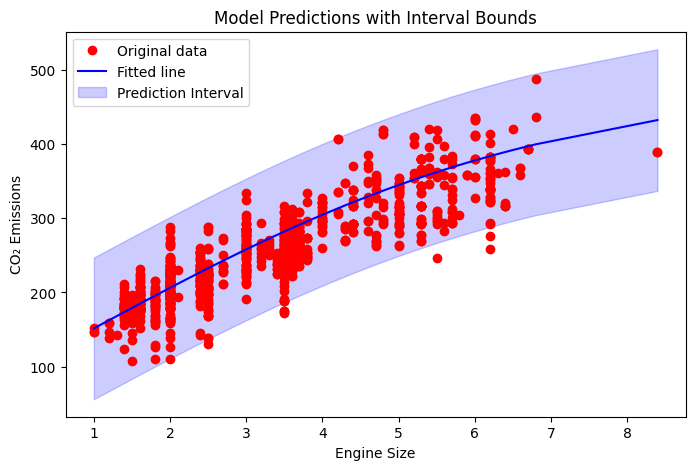

In [114]:
h_val = model.h.detach().numpy().item() * (y_scaler.data_max_ - y_scaler.data_min_)

# Sort by engine size for smooth line
sorted_idx = np.argsort(engine_size.flatten())
x_sorted = engine_size.flatten()[sorted_idx]
y_sorted = pred_emissions.flatten()[sorted_idx]

plt.figure(figsize=(8,5))

# Original data
plt.plot(engine_size, emissions, 'ro', label='Original data')

# Predicted mean
plt.plot(x_sorted, y_sorted, 'b-', label='Fitted line')

# Interval bounds (as shaded area)
plt.fill_between(
    x_sorted,
    y_sorted - h_val,
    y_sorted + h_val,
    color='blue',
    alpha=0.2,
    label='Prediction Interval'
)

plt.xlabel("Engine Size")
plt.ylabel("CO₂ Emissions")
plt.title("Model Predictions with Interval Bounds")
plt.legend()
plt.show()


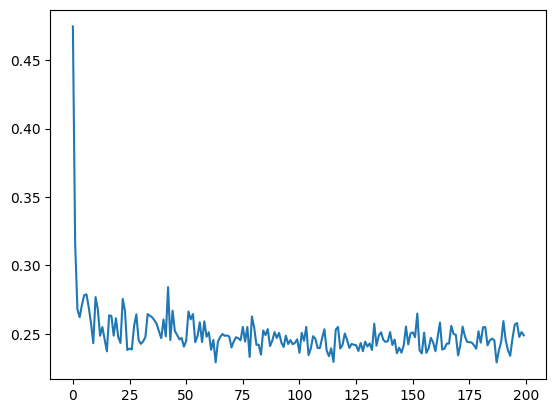

In [115]:
plt.plot(error_log)
plt.show()